# Monte_Carlo Problem (Playing Blackjack)

## First Visit MC Algorithm #9 (actions)

**Setup**
Let's import the correct dependencies

In [1]:
import sys
import gym
#gymspaces aren't imported by default anymore
import gym.spaces
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

In [2]:
# Create an environment "instance" for the Blackjack game
env = gym.make('Blackjack-v0')

Blackjack has 3 components to it's **States (s)** and hence ```s``` can be considered **a 3-tuple** of; 

* The players card sum between 0 and 31
```∈{0,1,…,31}```

* The dealers current face up card between 1 and 10
```∈{1,…,10}```

* Whether or not the player has a usable ace 
```no = 0, yes = 1```



The agent has two available **Actions (A)**;

```stick = 0 
hit = 1 ```


To verify the **state/observation** & **action** spaces we can run the following code

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Hence, we can see that there are ```704 states``` in total ``` (32*11*2)```

### A quick game using a Random Policy
The follow code will play the game 5 times

In [4]:
for i_episode in range(5):
    #create a new environment for the game
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward:', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(19, 10, False)
End game! Reward: -1.0
You lost :(

(13, 5, False)
End game! Reward: -1
You lost :(

(15, 7, False)
(21, 7, False)
End game! Reward: 1.0
You won :)

(16, 4, False)
End game! Reward: -1
You lost :(

(11, 10, False)
(19, 10, False)
End game! Reward: -1
You lost :(



## Part One MC Prediction

The first investigation will be implementing a policy where the player will ```STICK P(80|20)``` when the sum exceeds 18. 
If the sum is below 18, the agent will ```HIT P(80|20)```


After implementing this we use the function ```generate_episode_from_limit_stochastic``` samples an episode using the above policy.

The function accepts an ```input``` :
* the Open.AI Blackjack environment as  ```bj_env```

It returns the $episode$ as an ```output```:
* An ```episode``` is a list of the State, Action, Reward - a triple tupule of tupules, and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_T)$, where $T$ is the final time step. 
* e.g: ```episode[i]``` returns $(S_i, A_i, R_{i+1})$, and ```epsiode[i][0], episode[i][1], ```and ```episode[i][2]``` return $S_i, A_i$ and $R_{i+1}$, respectively. 

In [6]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    #reset the environment from previous interactions
    state = bj_env.reset()
    while True:
        #state policy probability; 80% if state (current sum) is below 18. Otherwise 20%
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        #our action is a random choice between a (an array with values between 0-2 and the probabilities stated)
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

#Run this policy 5 times
for i in range(5):
    print(generate_episode_from_limit_stochastic(env))

[((6, 1, False), 1, 0), ((10, 1, False), 1, 0), ((13, 1, False), 1, 0), ((17, 1, False), 1, 0), ((19, 1, False), 1, 0), ((20, 1, False), 0, -1.0)]
[((14, 9, False), 1, 0), ((16, 9, False), 1, -1)]
[((13, 10, False), 0, -1.0)]
[((17, 9, False), 1, -1)]
[((20, 10, False), 1, -1)]


## Part One.b

This algorithm has 3 arguements:
* ```env``` - The instance of the OpenAI Gym Environment
* ```num_episodes``` - The number of episodes that are generated through agent-environment interactions
* ```generate_episodes``` - A function that returns an episode of interaction
* $gamma$ - The discount rate and must have a value between ```0``` and ```1```

The arguement returns ```Q``` as an output: 
```Q``` is the dictionary (of one-dimensional arrays), where ```Q[s][a]``` is the estimated action-value corresponding to state ```s``` and action ```a```

In [7]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=0.73):
    
    
    # initialize dictionaries of arrays full of zeroes
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    
    # loop over episodes fn
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        #Generate an Episode
        episode = generate_episode(env)
        
        #Use the zip command to split state, actions & rewards into seperate quantities and use them to iterate dictionaries
        states, actions, rewards = zip(*episode)
        
        # Apply Discount Rate (g**{i} for all rewards_i+1)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        
        #Update the sum of the returns, number of visits, and action-value 
        for i, state in enumerate(states):
            
            # Return_Sum = Return_sum + sum of (rewards {1st value in tuple i:j} i, * 
            # discounts {update 2nd value in tuple from the last value backwards by 1+i, 1 step duh}
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            
            # update number of visits to N-dictionary
            N[state][actions[i]] += 1.0
            
            # Estimates for each state-action pair in episode.
            # The sum of s-a pairs divided by the total s-a pairs
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
        
        
    return Q



### let's take a quick detour

In [9]:
# a little bite sized block to understand the enumerate command and the loop updating s,a,r

example1 = [10, 20, 30, 40]
print(example1)

example2 = list(enumerate(example1))
print(example2)

print('/////////')

example = ['up', 'down', 'left', 'right']

for i in range(len(example)):
    print(i, example[i])

print('/////////')

for a, b in enumerate(example):
    print(a, b)
    
    
print('/////////')

new_dictionary = dict(enumerate(example))
print(new_dictionary)


## By looking at the output, we can see that when enumerate is combined with a for loop 
## we can access each i, j within the tuple example and the do something with those values
## such as print them in pairs i, j (Transposing the tuple into seperate s, a, r)

[10, 20, 30, 40]
[(0, 10), (1, 20), (2, 30), (3, 40)]
/////////
0 up
1 down
2 left
3 right
/////////
0 up
1 down
2 left
3 right
/////////
{0: 'up', 1: 'down', 2: 'left', 3: 'right'}


In [10]:
# and another to understand arrays and slicing because i actually dont know what im doing in python

apples = ("mouse", [8, 4, 6], 5, "data")
banana = ("one", [2,3,4], 10, 18)

# coooool, so here i'm going to print all values from 0 -> the last -1, with a 2 step interval!
print(apples)
print("/////////")
print(apples[0:-1:2])



('mouse', [8, 4, 6], 5, 'data')
/////////
('mouse', 5)


...

### Ok now finally we can get back to the actual algorithm




In [11]:

# we can run the following code to view the individual s, a, r values added to the dictionary

#print full dict.
episode = generate_episode_from_limit_stochastic(env)
print(episode)

#print seperated values
states, actions, rewards = zip(*episode)
print('\nstates: ', states)
print('\nactions: ', actions)
print('\nrewards: ', rewards)

[((19, 10, False), 0, -1.0)]

states:  ((19, 10, False),)

actions:  (0,)

rewards:  (-1.0,)


Episode 500000/500000.

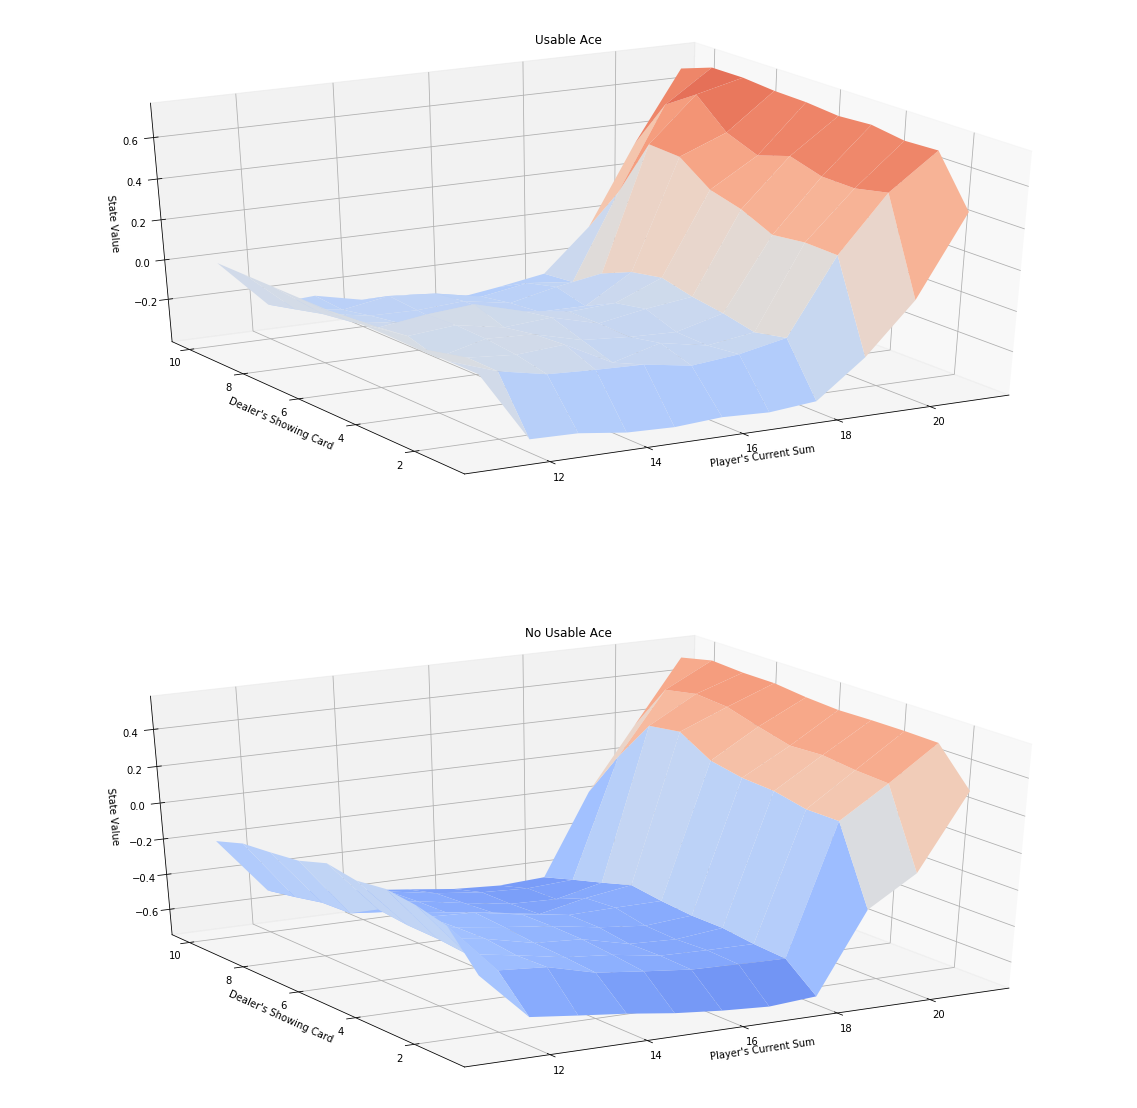

In [12]:


# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

# Part 2 - First Visit Constant-$\alpha$ GLIE MC Control Algorithm (11)

In [13]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q


def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
         # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [14]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, 0.02)

Episode 500000/500000.

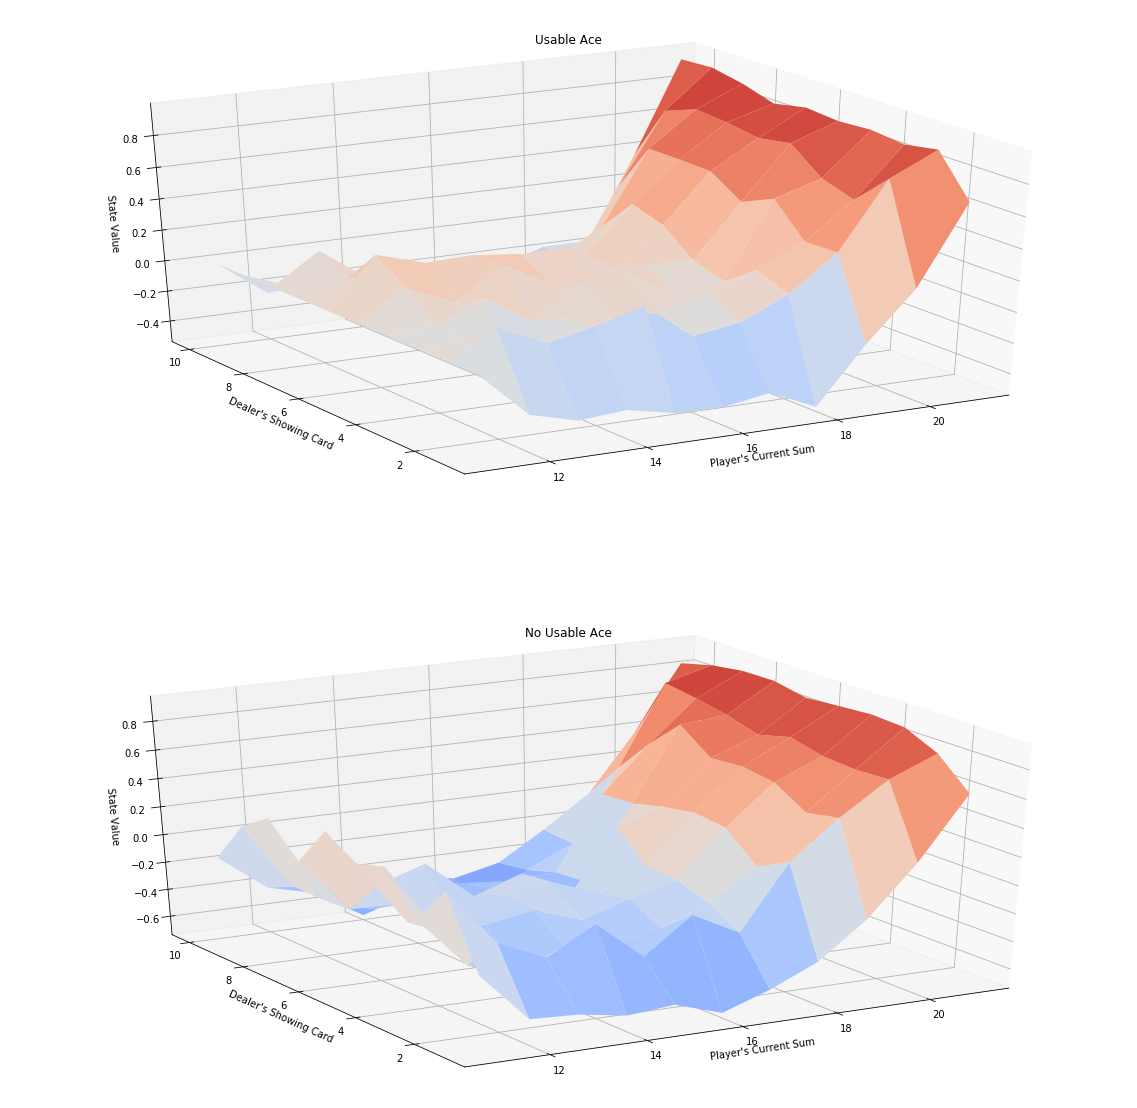

In [15]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

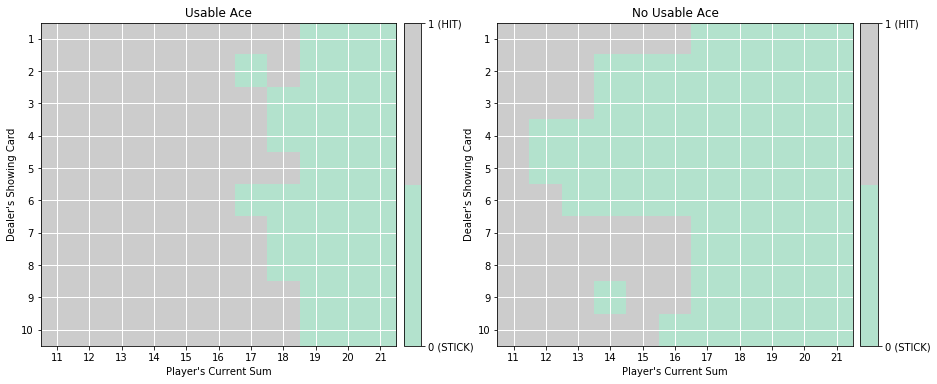

In [16]:
# plot the policy
plot_policy(policy)